Code to generate the plots used in the Nature Energy Submission

In [3]:
# Directory manipulation for relative notebook imports
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

# Relative import for relevant methods
from Visualization.plot_util import *
from Visualization.projection_plots import *
from Data.data_load_util import *
from Data.data_stats_util import *
from Simulation.projections_util import *
from Models.Neat.neat_util import *
from Simulation.projections import *


# Imports for ipynb visualization
import plotly.io as pio



In [9]:
# Data loading (including projections)
zips_df, state_df, pos_df = make_dataset(granularity='both', remove_outliers=False, load_dir_prefix='../Data/')

#update zips_df with 2025 panels
projection2025 = get_baseline_2025(zips_df, state_df, save="../Data/Baseline_2025/baseline.pkl", load="../Data/Baseline_2025/baseline.pkl")
zips_df = updated_df_with_picks(zips_df, projection2025.panel_placements)

#process data for EVA
data_manager = DataManager(zips_df, fields=['Median_income', 'carbon_offset_kg_per_panel', 'yearly_sunlight_kwh_kw_threshold_avg', 'panel_utilization', 'black_prop'])

proj_path_2m = "../Simulation/Projection_Saves/projections_2m_from_2025.pkl"
projections_2m = create_projections(zips_df, state_df, n_panels=2000000, save=proj_path_2m, load=proj_path_2m)
# projections = create_projections(zips_df, state_df, n_panels=2000000, save="../Simulation/Projection_Saves/projections_2mil.pkl", load="../Simulation/Projection_Saves/projections_2mil.pkl")

Loading from previous calculations...
Loading from previous simulation...


In [3]:
#get the EVA projection
with open(dir1 + "\\Models\\Neat\\models\\05-30-25\\NEAT_model_lexicase_weighted_3.pkl", 'rb') as f:
    network = pickle.load(f)

#2 million panels
neat_proj_path_2m = "../Simulation/Projection_Saves/projections_neat_2m_from_2025.pkl"
neat_proj_new_2m = create_neat_proj(data_manager, 2000000, NeatModel(network), create_paper_objectives(), save=neat_proj_path_2m, load=neat_proj_path_2m)


Loading from previous calculations...


In [4]:
# State map of carbon offset per panel added
plot_state_map(state_df, key='carbon_offset_metric_tons_per_panel', fill_color='Blues', legend_name="Carbon Offset Metric Tons Per Panel", save_dir_prefix="../Visualization/")


In [5]:
pio.renderers.default = "notebook"
geo_plot(zips_df['carbon_offset_metric_tons_per_panel'], 'mint', "Carbon Offset Per Panel", pos_df)

In [6]:
#fig 3
methods_colorpalette = ["#4a2377","#8cc5e3","#0d7d87", "#f55f74"]

compared_projections_2m = [projections_2m[1], projections_2m[2], projections_2m[3]] + [neat_proj_new_2m]
plot_projections(compared_projections_2m, "Carbon Offset", color_palette=methods_colorpalette, interval=100000)
plot_projections(compared_projections_2m, "Energy Potential", color_palette=methods_colorpalette, interval=100000)

NameError: name 'pio' is not defined

Carbon Optimized results: [np.float64(1.2651033942259082), np.float64(1.146291963659523), np.float64(0.9874380491945722), np.float64(1.0720339995682313)]
Energy Optimized results: [np.float64(1.1094289756776645), np.float64(1.1961463322355403), np.float64(1.0452263200923564), np.float64(1.108389619307412)]
EVA results: [np.float64(1.2568262473440188), np.float64(1.1689877502561319), np.float64(1.0702518690470524), np.float64(1.165040236880775)]


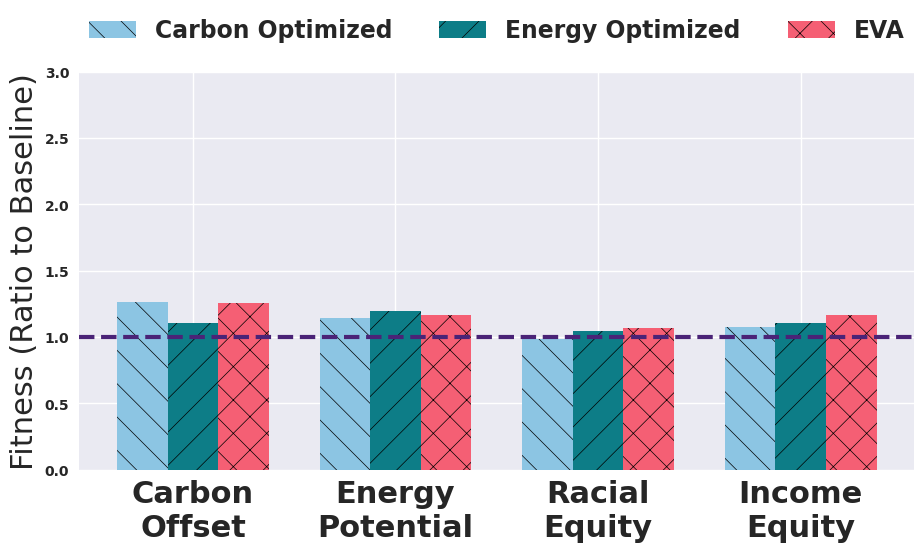

Carbon Optimized results: [np.float64(1.5486585704108347), np.float64(1.313942357055807), np.float64(1.032020222201648), np.float64(1.135734325621484)]
Energy Optimized results: [np.float64(1.2595664750365432), np.float64(1.4089031732245525), np.float64(1.0341966885279192), np.float64(1.1378422654648614)]
EVA results: [np.float64(1.5187369237458177), np.float64(1.3451180933151898), np.float64(1.116008331516186), np.float64(1.214908606733605)]


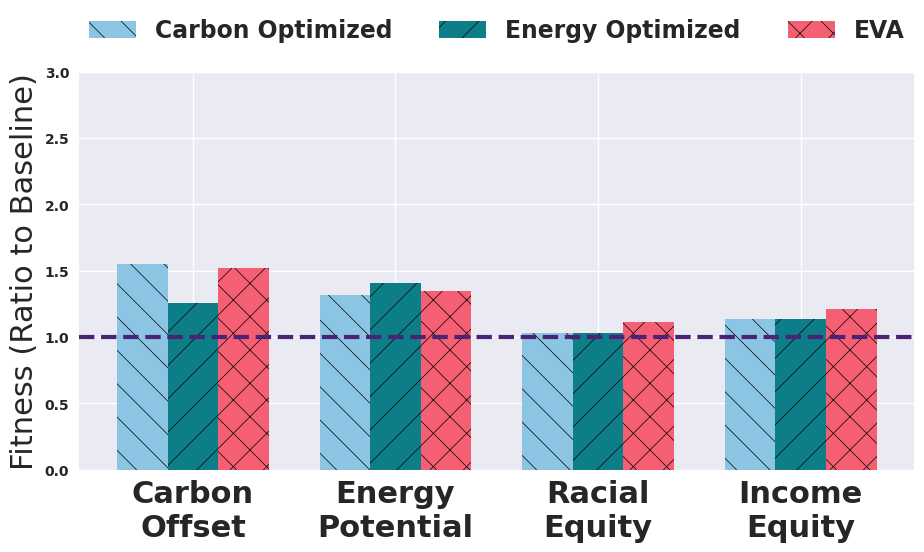

Carbon Optimized results: [np.float64(2.528324391533766), np.float64(1.8842058154199526), np.float64(1.1907956969915003), np.float64(1.432197099497321)]
Energy Optimized results: [np.float64(1.7611654669556003), np.float64(2.15782635295099), np.float64(0.9906909499372835), np.float64(1.2053214996156971)]
EVA results: [np.float64(2.3356682051461437), np.float64(2.0080798029613183), np.float64(1.2628848046968872), np.float64(1.443199408335038)]


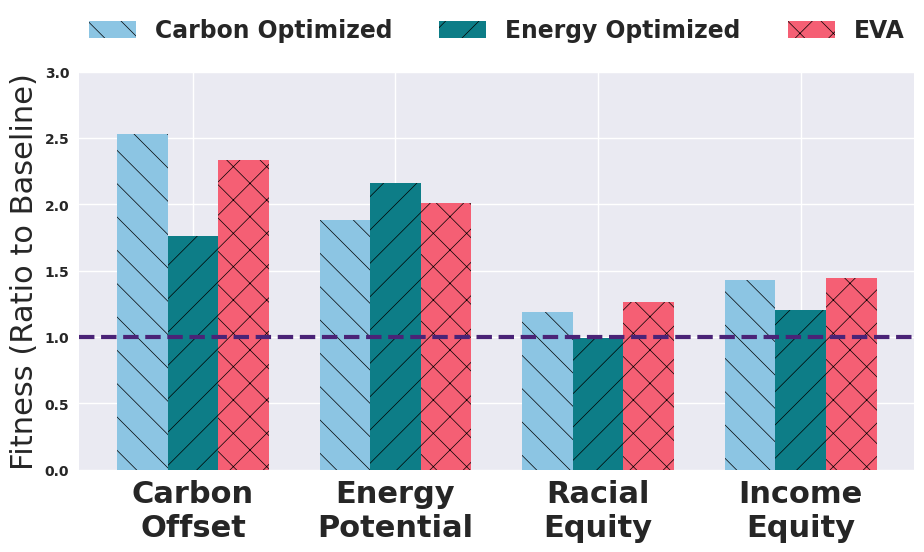

In [7]:
#fig 4
coverage_ratio = 674914/1600000 #ratio of panels covered by our dataset
annual_new_panels = [coverage_ratio * 720000 * 1.09**i for i in range(11)]

#get the baseline
installations2025 = 1973556
baseline2025 = {key: projection2025.objective_projections[key][installations2025] for key in projection2025.objective_projections.keys()}

for num_panels in [sum(annual_new_panels[:i]) for i in [1,2,5]]:
    plot_bar_comparison_baseline_ratio(baseline2025, [projections_2m[2], projections_2m[3], neat_proj_new_2m], panel_count=num_panels, color_palette = methods_colorpalette, hatches=["\\","/","x"], hatch_size=0.5, fontsize=22)


In [8]:
#get absolute projected objectives from EVA after 5 years (2030) and 10 years (2035)
for i in [5,10]:
    num_panels = sum(annual_new_panels[:i])
    proj1 = projections_2m[1].interpolateObjectiveProjections(num_panels)
    proj2 = neat_proj_new_2m.interpolateObjectiveProjections(num_panels)
    print("Years:", i)
    print("SQ Carbon offset:",proj1['Carbon Offset'])
    print("EVA Carbon offset:",proj2['Carbon Offset'])
    print("Carbon ratio:", proj2['Carbon Offset']/proj1['Carbon Offset'])

    print("SQ Energy Potential:",proj1['Energy Potential'])
    print("EVA Energy Potential:",proj2['Energy Potential'])
    print("Energy ratio:", proj2['Energy Potential']/proj1['Energy Potential'])
    print("----")

Years: 5
SQ Carbon offset: 279797.76400810695
EVA Carbon offset: 405777.69967177266
Carbon ratio: 1.4502535469154625
SQ Energy Potential: 2049736072.1784184
EVA Energy Potential: 2243562674.232418
Energy ratio: 1.0945617363546736
----
Years: 10
SQ Carbon offset: 307871.9549724879
EVA Carbon offset: 443355.98776588624
Carbon ratio: 1.4400661723329282
SQ Energy Potential: 2255401339.450712
EVA Energy Potential: 2474296003.479157
Energy ratio: 1.097053531094273
----


In [ ]:
a =  ( zips_df['existing_installs_count'] * zips_df['yearly_sunlight_kwh_kw_threshold_avg']) / zips_df['yearly_sunlight_kwh_total']
print(a)
print(zips_df['region_name'])

0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
           ...   
10539    0.000035
10540    0.000011
10541    0.000025
10542    0.000000
10543    0.000000
Length: 10544, dtype: float64


In [26]:
b = zips_df['count_qualified']
print(a/b)

0        21.764924
1        24.670712
2        20.874213
3        14.677950
4         8.613589
           ...    
10539    38.942505
10540    43.740364
10541    76.245469
10542    30.693624
10543    16.045330
Length: 10544, dtype: float64


In [22]:
state_df['black_or_hisp_prop'] = state_df['black_prop'] + state_df['hispanic_prop']
state_df['percent_cap_increase'] = state_df['Residential_cap_25'] / state_df['Residential_cap_24']
for x in ['black_prop', 'Median_income', 'Adjusted Payback Period (Years, under energy generation assumptions)']:
    for y in ['panel_utilization', 'carbon_offset_kg_per_panel', 'percent_cap_increase', 'yearly_sunlight_kwh_kw_threshold_avg']:
        stats = get_stats(state_df[x], state_df[y])
        print(x, "vs", y, stats['pearson'].statistic)

black_prop vs panel_utilization -0.00498283368184358
black_prop vs carbon_offset_kg_per_panel 0.22498613648617652
black_prop vs percent_cap_increase -0.21232308177313056
black_prop vs yearly_sunlight_kwh_kw_threshold_avg 0.043214933156340896
Median_income vs panel_utilization 0.37563513739461274
Median_income vs carbon_offset_kg_per_panel -0.36711375049613265
Median_income vs percent_cap_increase 0.027535557194900556
Median_income vs yearly_sunlight_kwh_kw_threshold_avg -0.18188941072702522
Adjusted Payback Period (Years, under energy generation assumptions) vs panel_utilization -0.3358555819947143
Adjusted Payback Period (Years, under energy generation assumptions) vs carbon_offset_kg_per_panel 0.13778019337062827
Adjusted Payback Period (Years, under energy generation assumptions) vs percent_cap_increase 0.10600360440311442
Adjusted Payback Period (Years, under energy generation assumptions) vs yearly_sunlight_kwh_kw_threshold_avg -0.05633805821276924
